In [3]:
import json
import re

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch

from ptvid.constants import ROOT
from ptvid.src.bert.model import LanguageIdentifier

FILENAME_PATTERN = re.compile(r"(.+)_pos_prob=(\d\.\d+)_ner_prob=(\d\.\d+)")

POS_PROBS = NER_PROBS = [
    0.0,
    0.1,
    0.2,
    0.30000000000000004,
    0.4,
    0.5,
    0.6000000000000001,
    0.7000000000000001,
    0.8,
    0.9,
    1.0
 ]

DOMAINS = ['politics', 'literature', 'journalistic', 'legal', 'social_media', 'web']

ROOT = ROOT.resolve()
BERT_RESULTS_DIR = ROOT.parent / "results" / "bert"
BERT_MODELS_DIR = ROOT.parent / "model" / "bert"

In [19]:
def read_metrics(filepath):
    metrics = {}
    for filepath in filepath.glob("**/*.json"):
        model_keyname = filepath.parent.name
        domain, pos_prob, ner_prob = FILENAME_PATTERN.match(model_keyname).groups()
        pos_prob = float(pos_prob)
        ner_prob = float(ner_prob)
        content = json.load(open(filepath))
        if domain not in metrics:
            metrics[domain] = {}

        content["pos_prob"] = pos_prob
        content["ner_prob"] = ner_prob
        content["model_keyname"] = model_keyname
        metrics[domain][pos_prob, ner_prob] = content
    return metrics


In [20]:
metrics = read_metrics(BERT_RESULTS_DIR)


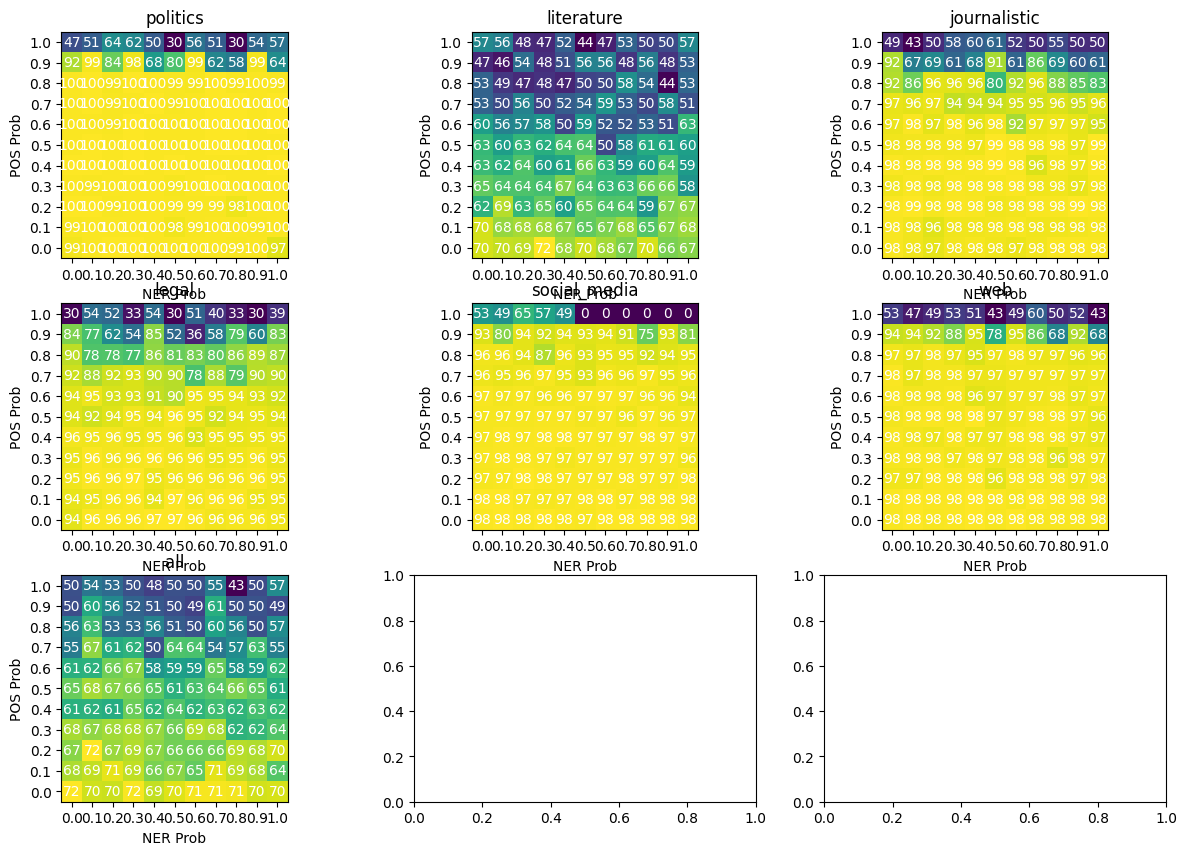

In [21]:
# make a heatmap for each domain having the pos_prob and ner_prob as the x and y axis
# the color should be the accuracy
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, domain in enumerate(metrics):
    ax = axs[i // 3, i % 3]
    data = metrics[domain]
    data = metrics[domain]
    matrix = np.zeros((len(POS_PROBS), len(NER_PROBS)))
    for i, pos_prob in enumerate(POS_PROBS[::-1]):
        for j, ner_prob in enumerate(NER_PROBS):
            if (pos_prob, ner_prob) in data:
                matrix[i, j] = data[pos_prob, ner_prob]["valid"]["acc"]
            else:
                matrix[i, j] = 0
    ax.set_title(domain)
    ax.set_xlabel("NER Prob")
    ax.set_ylabel("POS Prob")
    # make the heatmap
    im = ax.imshow(matrix, cmap="viridis")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(POS_PROBS)), labels=[round(p, 1) for p in POS_PROBS])
    ax.set_yticks(np.arange(len(NER_PROBS)), labels=[round(p, 1) for p in NER_PROBS[::-1]])


    for i in range(len(POS_PROBS)):
        for j in range(len(NER_PROBS)):
            text = ax.text(j, i, round(matrix[i, j]), ha="center", va="center", color="w")

plt.show()

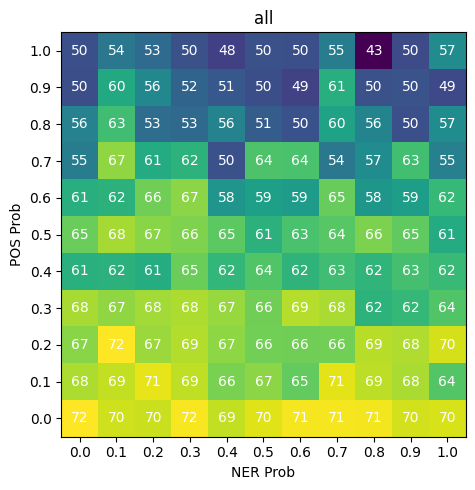

In [22]:
# make one heat map for the "all" domain
fig, ax = plt.subplots(figsize=(5, 5))

domain = "all"
data = metrics[domain]
matrix = np.zeros((len(POS_PROBS), len(NER_PROBS)))
for i, pos_prob in enumerate(POS_PROBS[::-1]):
    for j, ner_prob in enumerate(NER_PROBS):
        if (pos_prob, ner_prob) in data:
            matrix[i, j] = data[pos_prob, ner_prob]["valid"]["acc"]
        else:
            matrix[i, j] = np.nan
ax.set_title(domain)
ax.set_xlabel("NER Prob")
ax.set_ylabel("POS Prob")
# make the heatmap
im = ax.imshow(matrix, cmap="viridis")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(POS_PROBS)), labels=[round(p, 1) for p in POS_PROBS])
ax.set_yticks(np.arange(len(NER_PROBS)), labels=[round(p, 1) for p in NER_PROBS[::-1]])


for i in range(len(POS_PROBS)):
    for j in range(len(NER_PROBS)):
        text = ax.text(j, i, round(matrix[i, j]), ha="center", va="center", color="w")

fig.tight_layout()

plt.show()

In [23]:
matrix.round(1)

array([[49.9, 54.3, 53. , 50. , 48.4, 50. , 50. , 55. , 42.9, 49.5, 56.8],
       [49.8, 60.5, 56.4, 52.2, 50.8, 49.9, 48.6, 61. , 50. , 50.3, 49.2],
       [55.7, 63. , 53.2, 52.8, 55.8, 51.4, 50.2, 59.5, 55.9, 49.9, 56.9],
       [55. , 67. , 60.7, 61.6, 50.1, 63.7, 63.5, 54.4, 57. , 63.1, 55.5],
       [61.1, 61.5, 65.6, 66.8, 58. , 59.2, 58.9, 65.1, 58.2, 59.1, 62.3],
       [65.2, 67.9, 66.7, 66.2, 64.5, 61.4, 63.5, 64.3, 66.2, 64.8, 60.7],
       [61.2, 61.5, 60.7, 65.3, 62. , 64. , 61.7, 63. , 61.8, 63.3, 62.4],
       [68. , 67. , 67.8, 68.2, 67.3, 65.5, 68.5, 68.2, 61.5, 62.1, 64. ],
       [66.7, 71.7, 67.5, 68.5, 66.8, 65.6, 65.6, 65.6, 68.7, 68.4, 70. ],
       [68.3, 69.1, 70.7, 69. , 66. , 66.8, 64.8, 70.6, 68.9, 68.2, 64.1],
       [71.8, 69.7, 69.5, 71.6, 69.2, 70.4, 71.4, 71.4, 71.2, 69.8, 70. ]])

## Test All Model

In [24]:
best_per_domain = {}
for domain, data in metrics.items():
    best_metric = None
    for x in data:
        if best_metric is None or data[x]["valid"]["acc"] > best_metric["valid"]["acc"]:
            best_metric = data[x]
    best_per_domain[domain] = best_metric
    

In [31]:
model_keyname = best_per_domain["all"]["model_keyname"]
model_keyname

'all_pos_prob=0.0_ner_prob=0.0'

In [26]:
modelpath = BERT_MODELS_DIR / model_keyname / "model.pth"

In [27]:
model = LanguageIdentifier()

In [28]:
checkpoint = torch.load(modelpath)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [29]:
model

LanguageIdentifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [30]:
model.predict(["Isto é um teste.", "O cara apanhou o autocarro"])

ValueError: expected sequence of length 7 at dim 1 (got 10)

## Datasets

In [30]:
import datasets

from collections import Counter
from ptvid.constants import LABEL2ID

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

In [6]:
dsl = datasets.load_dataset("LCA-PORVID/dsl_tl", split="test")

Generating test split: 100%|██████████| 991/991 [00:00<00:00, 319907.28 examples/s]


In [17]:
dsl = dsl.filter(lambda x: x["label"] in [0, 1])
dsl

Filter: 100%|██████████| 857/857 [00:00<00:00, 75623.13 examples/s]


Dataset({
    features: ['text', 'label'],
    num_rows: 857
})

In [9]:
count = Counter(dsl['label'])
count

Counter({1: 588, 0: 269, 2: 134})

In [32]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="liaad/LVI_bert-large-portuguese-cased", device="cuda")

In [33]:
# run pipe on the dsl dataset
pred = pipe(dsl['text'])


In [34]:
pred = [LABEL2ID[p["label"]] for p in pred]


In [35]:
print(f"Accuracy: {accuracy_score(dsl['label'], pred)}")
print(f"Precision: {precision_score(dsl['label'], pred)}")
print(f"Recall: {recall_score(dsl['label'], pred)}")
print(f"F1: {f1_score(dsl['label'], pred)}")

Accuracy: 0.8109684947491248
Precision: 0.9346938775510204
Recall: 0.7789115646258503
F1: 0.849721706864564


In [37]:
print(classification_report(dsl['label'], pred, target_names=["PT", "BR"]))

              precision    recall  f1-score   support

          PT       0.65      0.88      0.75       269
          BR       0.93      0.78      0.85       588

    accuracy                           0.81       857
   macro avg       0.79      0.83      0.80       857
weighted avg       0.84      0.81      0.82       857



In [52]:
frmt = datasets.load_dataset("hugosousa/frmt", split="test")
pt = [text for text in frmt["pt"] if text]
br = [text for text in frmt["br"] if text]

labels = [0] * len(pt) + [1] * len(br)
text = pt + br

frmt = datasets.Dataset.from_dict({"text": text, "label": labels})

In [60]:
pred = pipe(frmt['text'])
pred = [LABEL2ID[p["label"]] for p in pred]

In [61]:
print(f"Accuracy: {accuracy_score(frmt['label'], pred)}")
print(f"Precision: {precision_score(frmt['label'], pred)}")
print(f"Recall: {recall_score(frmt['label'], pred)}")
print(f"F1: {f1_score(frmt['label'], pred)}")

Accuracy: 0.7667432070417145
Precision: 0.7535493265380415
Recall: 0.7924961715160797
F1: 0.7725321888412017


In [62]:
print(classification_report(frmt['label'], pred, target_names=["PT", "BR"]))

              precision    recall  f1-score   support

          PT       0.78      0.74      0.76      2614
          BR       0.75      0.79      0.77      2612

    accuracy                           0.77      5226
   macro avg       0.77      0.77      0.77      5226
weighted avg       0.77      0.77      0.77      5226



In [1]:
import json
from collections import Counter

import datasets
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from transformers import pipeline

from ptvid.constants import LABEL2ID

MODELS = [
    "liaad/LVI_bert-base-portuguese-cased",
    "liaad/LVI_bert-large-portuguese-cased",
    "liaad/LVI_albertina-100m-portuguese-ptpt-encoder",
    "liaad/LVI_albertina-900m-portuguese-ptpt-encoder",
]


def load_dsl():
    dsl = datasets.load_dataset("LCA-PORVID/dsl_tl", split="test")
    dsl = dsl.filter(lambda x: x["label"] in [0, 1])
    return dsl


def load_frmt():
    frmt = datasets.load_dataset("hugosousa/frmt", split="test")
    pt = [text for text in frmt["pt"] if text]
    br = [text for text in frmt["br"] if text]

    labels = [0] * len(pt) + [1] * len(br)
    text = pt + br

    return datasets.Dataset.from_dict({"text": text, "label": labels})


def evaluate(pipe, dataset):
    pred = pipe(dataset["text"])
    pred = [LABEL2ID[p["label"]] for p in pred]
    metrics = {
        "accuracy": accuracy_score(dataset["label"], pred),
        "precision": precision_score(dataset["label"], pred),
        "recall": recall_score(dataset["label"], pred),
        "f1": f1_score(dataset["label"], pred),
    }

    print(classification_report(dataset["label"], pred, target_names=["PT", "BR"]))
    return metrics


/home/ubuntu/projects/Language-Identifier/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
frmt = load_frmt()
dsl = load_dsl()

results = {"frmt": {}, "dsl": {}}
for model_name in MODELS:
    print(f"Model: {model_name}")
    print("FRMT")
    pipe = pipeline("text-classification", model=model_name, device="cuda")
    results["frmt"][model_name] = evaluate(pipe, frmt)

    print("DSL")
    print(f"Model: {model_name}")
    pipe = pipeline("text-classification", model=model_name, device="cuda")
    results["dsl"][model_name] = evaluate(pipe, dsl)

Model: liaad/LVI_bert-base-portuguese-cased
FRMT
              precision    recall  f1-score   support

          PT       0.67      0.68      0.68      2614
          BR       0.68      0.67      0.67      2612

    accuracy                           0.68      5226
   macro avg       0.68      0.68      0.68      5226
weighted avg       0.68      0.68      0.68      5226

DSL
Model: liaad/LVI_bert-base-portuguese-cased
              precision    recall  f1-score   support

          PT       0.61      0.86      0.71       269
          BR       0.92      0.75      0.83       588

    accuracy                           0.79       857
   macro avg       0.77      0.80      0.77       857
weighted avg       0.82      0.79      0.79       857

Model: liaad/LVI_bert-large-portuguese-cased
FRMT
              precision    recall  f1-score   support

          PT       0.78      0.74      0.76      2614
          BR       0.75      0.79      0.77      2612

    accuracy                       